In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pywt
import pandas as pd
import scipy.stats as stats

from scipy.io import loadmat

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

### Load the data

In [2]:
# load the data
n_subj = 27

emg_data_E1={}
stimulus_E1={}
repetition_E1={}

for i in range(n_subj):
    data_E1 = loadmat("data/S%d_A1_E1.mat"%(i+1))
    emg_data_E1[i] = data_E1["emg"]
    stimulus_E1[i] = data_E1["stimulus"]
    repetition_E1[i] = data_E1["repetition"]

In [6]:
# store sizes
n_channels = emg_data_E1[0].shape[1]
n_stimuli = int(np.unique(stimulus_E1[0]).size - 1)  # remove rest
n_repetitions = int(np.unique(repetition_E1[0]).size - 1)  # remove rest

n_epochs = n_stimuli * n_repetitions
n_tsteps = 500 #because of subject 13

In [7]:
emg_tensor_E1 = np.zeros((n_subj, n_stimuli, n_repetitions, n_tsteps, n_channels))
for n in range(n_subj):
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            sel = np.squeeze(np.logical_and(stimulus_E1[n] == (i + 1), repetition_E1[k] == (j + 1)))
            emg_selected_data = emg_data_E1[n][sel, :]
            emg_tensor_E1[n, i, j, :, :] = emg_selected_data[:n_tsteps, :]

In [8]:
# Example of features
def features_estimation(signal, fs):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :return: total_feature_matrix -- python list
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal)
    frequency_matrix = frequency_features_estimation(signal, fs)
    time_frequency_matrix = time_frequency_features_estimation(signal)
    total_feature_matrix = np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix))

    return total_feature_matrix


def time_features_estimation(signal):
    """
    Compute time features from signal
    :param signal: numpy array signal.
    """

    th = np.mean(signal) + 3 * np.std(signal)

    variance = (np.var(signal))
    rms = (np.sqrt(np.mean(signal ** 2)))
    iemg = (np.sum(abs(signal)))  # Integral
    mav = (np.sum(np.absolute(signal)) / len(signal))  # Mean Absolute Value
    log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))
    wl = (np.sum(abs(np.diff(signal))))  # Wavelength
    aac = (np.sum(abs(np.diff(signal))) / len(signal))  # Average Amplitude Change
    dasdv = (math.sqrt((1 / (len(signal) - 1)) * np.sum((np.diff(signal)) ** 2)))  # Difference absolute standard deviation value
    zc = (zcruce(signal, th))  # Zero-Crossing
    wamp = (wilson_amplitude(signal, th))  # Willison amplitude
    myop = (myopulse(signal, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    return time_features_matrix


def frequency_features_estimation(signal, fs):
    """
    Compute frequency features from signal
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    frequency, power = spectrum(signal, fs)
    
    mnp = (np.sum(power) / len(power))  # Mean power
    tot = (np.sum(power))  # Total power
    mnf = (mean_freq(frequency, power))  # Mean frequency
    mdf = (median_freq(frequency, power))  # Median frequency
    pkf = (frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


def time_frequency_features_estimation(signal):
    """
    Compute time-frequency features from signal
    :param signal: numpy array signal.
    :return: h_wavelet: list
    """
    h_wavelet = []

    E_a, E = wavelet_energy(signal, 'db2', 4)
    E.insert(0, E_a)
    E = np.asarray(E) / 100

    h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)


def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power

def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce


def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def med_freq(f, P):
    Ptot = np.sum(P) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += P[i]
        errel = (Ptot - temp) / Ptot
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return f[i]

In [9]:
fs = 100 # set frequency
out = features_estimation(signal=emg_tensor_E1[0, 0, 0, :, 1], fs=100)
out.shape

(1, 17)

In [114]:
# extract all the features with using features_estimation
labels = []
emg_features = {}
labels_dict = {}
for n in range(n_subj):
    all_feature_list = []
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            channelwise_feature_list = []
            for k in range(n_channels):
                current_channel_features = features_estimation(signal=emg_tensor_E1[n, i, j, :, k], fs=fs)
                channelwise_feature_list.append(current_channel_features)
            channelwise_features = np.hstack(channelwise_feature_list)
            all_feature_list.append(channelwise_features)
            labels.append(i)
            
    # store for each subject
    emg_features[n] = np.vstack(all_feature_list)
    labels_dict[n] = np.array(labels)

C:\Users\maxim\AppData\Local\Temp\ipykernel_11552\3696181045.py:35: RuntimeWarning: divide by zero encountered in log10
  log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))


In [119]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", 
    "WL", "ACC", "DASDV", "ZC", "WAMP", 
    "MYOP", "MNP", "TP", "MNF", "MDF",
    "PKF", "WENT"
]
n_features_per_channel = len(feature_names)

<AxesSubplot: >

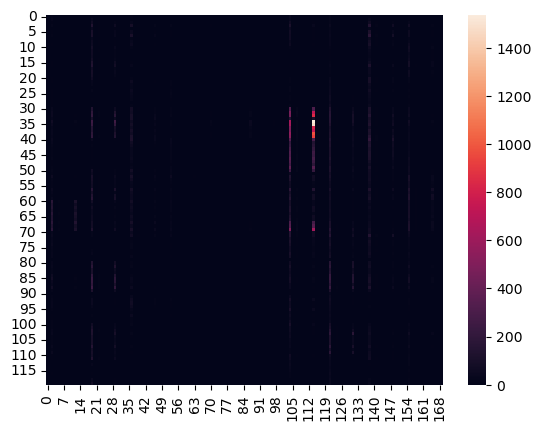

In [120]:
# check for meaningless features
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[0])


<AxesSubplot: >

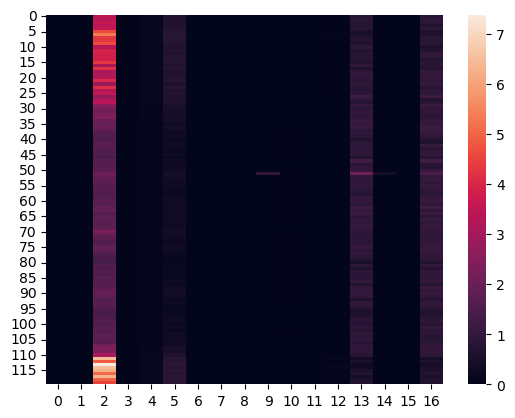

In [121]:
fig, ax = plt.subplots()
sns.heatmap(data=emg_features[10][:, :n_features_per_channel], ax=ax)

In [122]:
np.expand_dims(np.min(emg_features, axis=0), axis=0).shape

(1,)

C:\Users\maxim\AppData\Local\Temp\ipykernel_11552\110865631.py:7: RuntimeWarning: invalid value encountered in divide
  emg_minmax = (emg_features[n] - emg_mins) / (emg_maxs - emg_mins)


<AxesSubplot: >

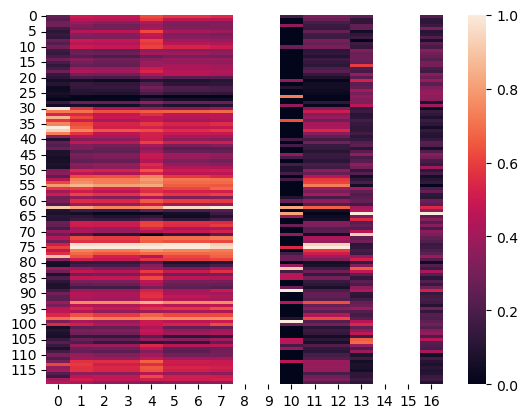

In [134]:
n=14
emg_mins = np.expand_dims(np.min(emg_features[n], axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features[n], axis=0), axis=0)
emg_mins = np.tile(emg_mins, [emg_features[n].shape[0], 1])
emg_maxs = np.tile(emg_maxs, [emg_features[n].shape[0], 1])

emg_minmax = (emg_features[n] - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :n_features_per_channel], ax=ax)

Features 8, 9 and 15 are meaningless.

# TODO : See with feature 14

C:\Users\maxim\AppData\Local\Temp\ipykernel_11552\1337698734.py:16: RuntimeWarning: invalid value encountered in divide
  emg_minmax = (emg_features_ok[n] - emg_mins) / (emg_maxs - emg_mins)


<AxesSubplot: >

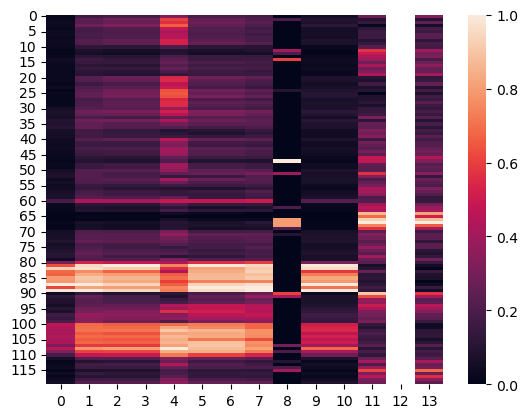

In [135]:
# feature 8, 9, 15 are meaningless for these data
feature_8 = np.arange(start=8, stop=170, step=17)
feature_9 = np.arange(start=9, stop=170, step=17)
feature_15 = np.arange(start=15, stop=170, step=17)
bad_cols = np.hstack((multiples_8, feature_9, multiples_15))
emg_features_ok = {}
for n in range(n_subj):
    emg_features_ok[n] = np.delete(emg_features[n], bad_cols, 1)

n=20
emg_mins = np.expand_dims(np.min(emg_features_ok[n], axis=0), axis=0)
emg_maxs = np.expand_dims(np.max(emg_features_ok[n], axis=0), axis=0)
emg_mins = np.tile(emg_mins, [emg_features_ok[n].shape[0], 1])
emg_maxs = np.tile(emg_maxs, [emg_features_ok[n].shape[0], 1])

emg_minmax = (emg_features_ok[n] - emg_mins) / (emg_maxs - emg_mins)
fig, ax = plt.subplots()
sns.heatmap(emg_minmax[:, :(n_features_per_channel - 3)], ax=ax)

In [112]:
emg_features_ok[2].shape

(360, 140)

### See the correlation between the features

In [136]:
feature_names = [
    "VAR", "RMS", "IEMG", "MAV", "LOG", "WL", 
    "ACC", "DASDV", "ZC", "WAMP", 'MYOP', "MNP", 
    "TP", "MNF", "MDF", "PKF", "WENT"
]

[]

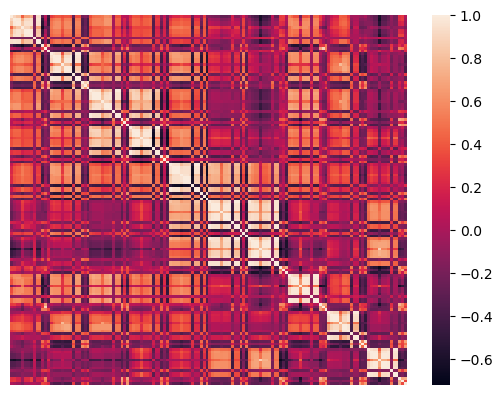

In [139]:
# correlation

n=16

all_feature_crosscorr = np.corrcoef(emg_features_ok[n].T)
fig, ax = plt.subplots()
sns.heatmap(data=all_feature_crosscorr, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

In [140]:
from scipy.stats import zscore

In [141]:
emg_features_norm={}

for n in range(n_subj):
    emg_features_norm[n] = zscore(emg_features_ok[n], axis=1)

### Split the Data for the model

In [142]:
from sklearn.model_selection import train_test_split

In [145]:
emg_features_norm_full = emg_features_norm[0]
for n in range(1, n_subj):
    emg_features_norm_full = np.vstack([emg_features_norm_full, emg_features_norm[n]])

In [146]:
emg_features_norm_full.shape

(3240, 140)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(emg_features_norm_full, labels, test_size=0.2)

In [153]:
selector = SelectKBest(f_classif)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

In [156]:
print(selector)

SelectKBest()
